## Multi-Class LGBM CV and Seed Diversification
_By Nick Brooks, June 2018_

**Contains:**
- Data Load
- Feature Engineering
- Exploratory Data Analysis
- Light GBM Cross Validation
- Seed Diversification
- Feature Importance

**Load:** <br>

In [1]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import random
random.seed(2018)
import re

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from IPython.display import display

# Gradient Boosting
import lightgbm as lgb

# Text Models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# TSNE
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Specify index/ target name
id_col = "Id"
target_var = "Cover_Type"

# House Keeping Parameters
Debug = False
Home = False
Build_Results_csv = False # if running for first time at Home

results = pd.DataFrame(columns = ["Rounds","Score","STDV", "LB", "Parameters"])
if Build_Results_csv is True & Home is True: results.to_csv("results.csv")
if Home is True:
    import os
    path = r"D:\\dev\\rocky\\persuasion_model\\static\\forest-cover-type-kernels-only"
    os.chdir(path)
    
    print("Data Load Stage")
    training = pd.read_csv(r"D:\\dev\\rocky\\persuasion_model\\static\\forest-cover-type-kernels-only\\train.csv\\train.csv", index_col = id_col)
    if Debug is True : training = training.sample(500)
    traindex = training.index
    testing = pd.read_csv(r"D:\\dev\\rocky\\persuasion_model\\static\\forest-cover-type-kernels-only\\test.csv\\test.csv", index_col = id_col)
    if Debug is True : testing = testing.sample(500)
    testdex = testing.index
else:
    print("Data Load Stage")
    training = pd.read_csv(r"D:\\dev\\rocky\\persuasion_model\\static\\forest-cover-type-kernels-only\\train.csv\\train.csv", index_col = id_col)
    if Debug is True : training = training.sample(100)
    traindex = training.index
    testing = pd.read_csv(r"D:\\dev\\rocky\\persuasion_model\\static\\forest-cover-type-kernels-only\\test.csv\\test.csv", index_col = id_col)
    if Debug is True : testing = testing.sample(100)
    testdex = testing.index

y = training[target_var]
training.drop(target_var,axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Data Load Stage
Train shape: 15120 Rows, 54 Columns
Test shape: 565892 Rows, 54 Columns
Combine Train and Test

All Data shape: 581012 Rows, 54 Columns


**Class Distribution:** <br>
This is crucial for all classification problems. Since unbalanced classes must be delt with the appropriate metrics, re-sampling, and stratification methods.

In [2]:
y_trees = y.map({1: "Spruce/Fir", 2: "Lodgepole Pine", 3: "Ponderosa Pine",
                 4: "Cottonwood/Willow",5:"Aspen",6:"Douglas-fir",7:"Krummholz"})
print("Percent Class Distribution:")
print(y_trees.value_counts(normalize=True)*100)
display(df.head())

Percent Class Distribution:
Lodgepole Pine       14.285714
Aspen                14.285714
Cottonwood/Willow    14.285714
Ponderosa Pine       14.285714
Spruce/Fir           14.285714
Douglas-fir          14.285714
Krummholz            14.285714
Name: Cover_Type, dtype: float64


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,0
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,0
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0


These classes are balanced! We can proceed.

***
## Feature Engineering

- Time Difference Features
- Product of Elevation and Slope
- Bag-Of-Words on Soil Description
- Lathwal Distance Features

In [3]:
print("Engineering Text Features:")
# Shade Difference
df["Hillshade-9_Noon_diff"] = df["Hillshade_9am"] - df["Hillshade_Noon"]
df["Hillshade-noon_3pm_diff"] = df["Hillshade_Noon"] - df["Hillshade_3pm"]
df["Hillshade-9am_3pm_diff"] = df["Hillshade_9am"] - df["Hillshade_3pm"]

# Mountain Trees
df["Slope*Elevation"] = df["Slope"] * df["Elevation"] # Only some trees can grow on steep montain tops

# Text Features from Description
soil_descriptions = {
    1: "Cathedral family - Rock outcrop complex, extremely stony.",
    2: "Vanet - Ratake families complex, very stony.",
    3: "Haploborolis - Rock outcrop complex, rubbly.",
    4: "Ratake family - Rock outcrop complex, rubbly.",
    5: "Vanet family - Rock outcrop complex complex, rubbly.",
    6: "Vanet - Wetmore families - Rock outcrop complex, stony.",
    7: "Gothic family.",
    8: "Supervisor - Limber families complex.",
    9: "Troutville family, very stony.",
    10: "Bullwark - Catamount families - Rock outcrop complex, rubbly.",
    11: "Bullwark - Catamount families - Rock land complex, rubbly.",
    12: "Legault family - Rock land complex, stony.",
    13: "Catamount family - Rock land - Bullwark family complex, rubbly.",
    14: "Pachic Argiborolis - Aquolis complex.",
    15: "unspecified in the USFS Soil and ELU Survey.",
    16: "Cryaquolis - Cryoborolis complex.",
    17: "Gateview family - Cryaquolis complex.",
    18: "Rogert family, very stony.",
    19: "Typic Cryaquolis - Borohemists complex.",
    20: "Typic Cryaquepts - Typic Cryaquolls complex.",
    21: "Typic Cryaquolls - Leighcan family, till substratum complex.",
    22: "Leighcan family, till substratum, extremely bouldery.",
    23: "Leighcan family, till substratum - Typic Cryaquolls complex.",
    24: "Leighcan family, extremely stony.",
    25: "Leighcan family, warm, extremely stony.",
    26: "Granile - Catamount families complex, very stony.",
    27: "Leighcan family, warm - Rock outcrop complex, extremely stony.",
    28: "Leighcan family - Rock outcrop complex, extremely stony.",
    29: "Como - Legault families complex, extremely stony.",
    30: "Como family - Rock land - Legault family complex, extremely stony.",
    31: "Leighcan - Catamount families complex, extremely stony.",
    32: "Catamount family - Rock outcrop - Leighcan family complex, extremely stony.",
    33: "Leighcan - Catamount families - Rock outcrop complex, extremely stony.",
    34: "Cryorthents - Rock land complex, extremely stony.",
    35: "Cryumbrepts - Rock outcrop - Cryaquepts complex.",
    36: "Bross family - Rock land - Cryumbrepts complex, extremely stony.",
    37: "Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.",
    38: "Leighcan - Moran families - Cryaquolls complex, extremely stony.",
    39: "Moran family - Cryorthents - Leighcan family complex, extremely stony.",
    40: "Moran family - Cryorthents - Rock land complex, extremely stony.."
    }
# First Isolate Soil Columns
soil_columns = [col for col in df.columns if col.startswith('Soil_Type')]
# Then get number
get_soil_number = [int(re.findall('\d+', x )[0]) for x in soil_columns]

# Since these are binary variables, map 1 to the description, and 0 to nothing
for soil_num in get_soil_number:
    df["mapped_Soil_Type" + str(soil_num)] = df["Soil_Type"+str(soil_num)].map({0: " ",1: soil_descriptions[soil_num]})

# Isolate my mappedcolumns within Df
mapped_columns = [col for col in df.columns if col.startswith('mapped_Soil_Type')]
# Join mapped columns so that I can apply text model
df["description"] = df[mapped_columns].apply(lambda x: ' '.join(x), axis=1)
# Drop mapped columns since they have been concentrted into 'description'
df.drop(mapped_columns,axis=1,inplace=True)

# Term Frequency - Inverse Document Frequency
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),
    dtype = np.float32,
    norm='l2',
    min_df=0,
    smooth_idf=False)

# Fit and Transform
word_features = word_vectorizer.fit_transform(df["description"])
df1 = pd.DataFrame(word_features.toarray(), columns=word_vectorizer.get_feature_names())
display(df1.sample(5))

Engineering Text Features:


,aquolis,aquolis complex,argiborolis,argiborolis aquolis,argiborolis aquolis complex,borohemists,borohemists complex,bouldery,bross,bross family,...,vanet wetmore,vanet wetmore families,warm,warm extremely,warm extremely stony,warm rock,warm rock outcrop,wetmore,wetmore families,wetmore families rock
80235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Word Cloud for Text Feature

Word Cloud Function Done


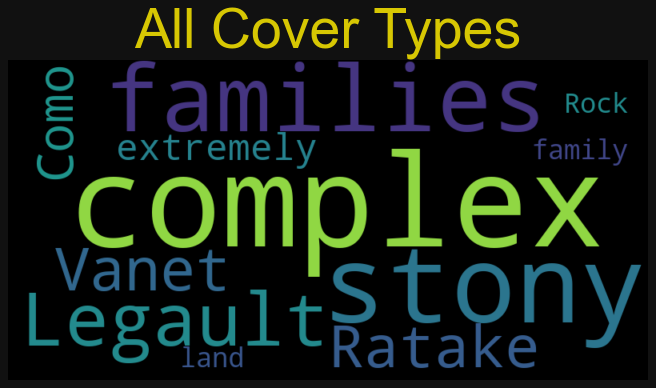

Description by Cover Type


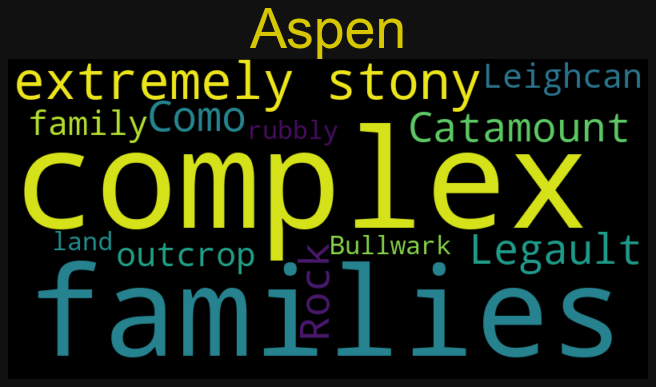

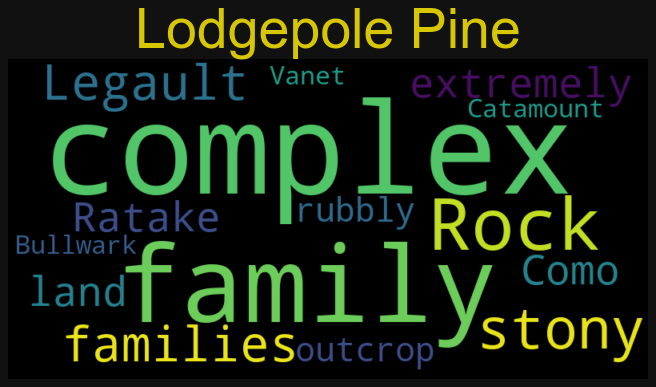

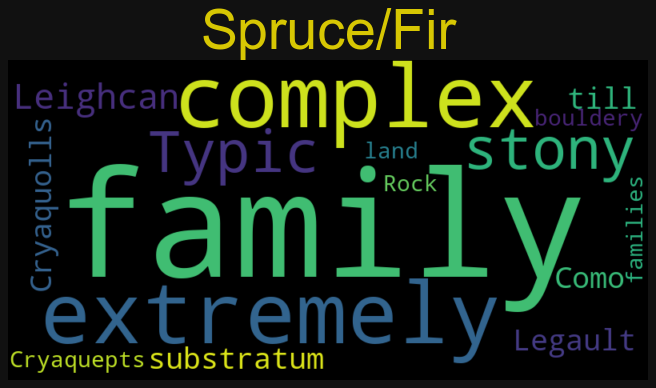

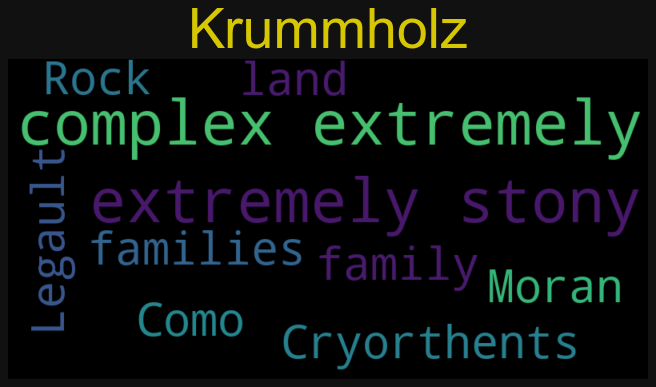

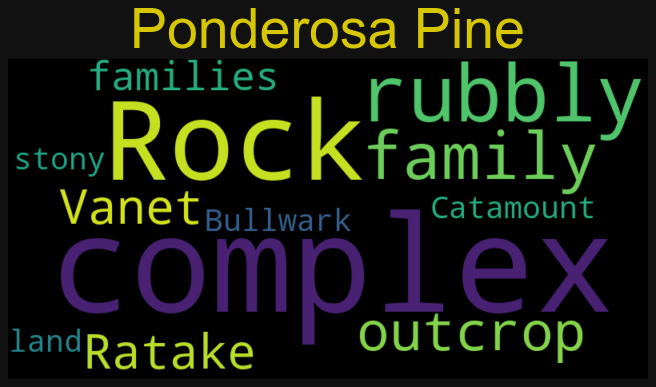

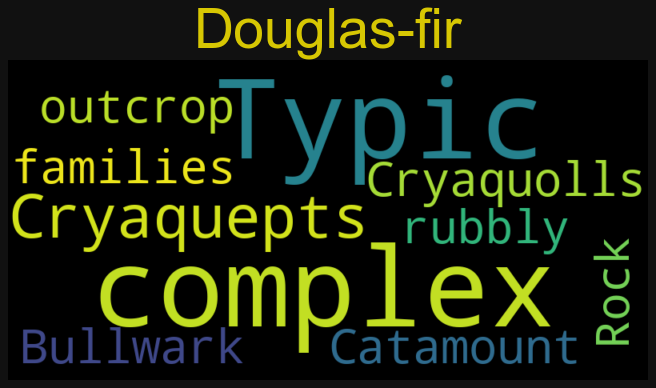

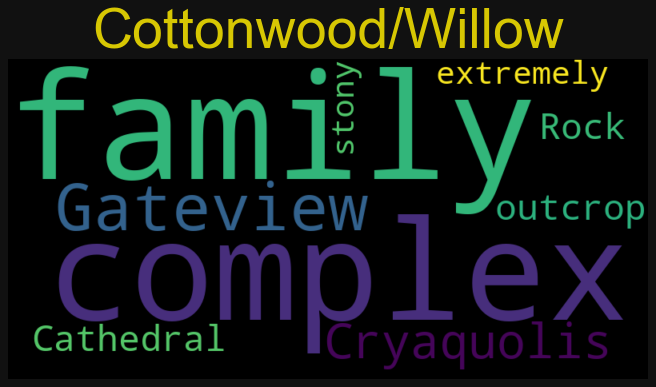

In [4]:
stopwords = set(STOPWORDS)
size = (6,3)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    # Processing Text
    # Redundant when combined with my Preprocessing function
    wordcloud = WordCloud(width=800, height=400,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
   # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()
print("Word Cloud Function Done")

# Data Set for Word Clouds
cloud_df = pd.concat([df.loc[traindex,'description'], y_trees],axis=1)
cloud(df["description"].values, title="All Cover Types", size=[8,5])

print("Description by Cover Type")
cloud_df = pd.concat([df.loc[traindex,'description'], y_trees],axis=1)
for cover in cloud_df.Cover_Type.unique():
    cloud(cloud_df.loc[cloud_df.Cover_Type == cover, "description"].values, title="{}".format(cover), size=[8,5])

**Lathwal Features:** <br>

In [5]:
# Features By Lathwal - Source: https://www.kaggle.com/codename007/forest-cover-type-eda-baseline-model
df['HF1'] = df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Fire_Points']
df['HF2'] = abs(df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Fire_Points'])
df['HR1'] = abs(df['Horizontal_Distance_To_Hydrology']+df['Horizontal_Distance_To_Roadways'])
df['HR2'] = abs(df['Horizontal_Distance_To_Hydrology']-df['Horizontal_Distance_To_Roadways'])
df['FR1'] = abs(df['Horizontal_Distance_To_Fire_Points']+df['Horizontal_Distance_To_Roadways'])
df['FR2'] = abs(df['Horizontal_Distance_To_Fire_Points']-df['Horizontal_Distance_To_Roadways'])

## Train and Test Data Split

In [6]:
test_df.shape


NameError: name 'test_df' is not defined

In [17]:
df.loc[traindex,vocab]

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,vanet wetmore,vanet wetmore families,warm,warm extremely,warm extremely stony,warm rock,warm rock outcrop,wetmore,wetmore families,wetmore families rock
Id,,,,,,,,,,,,,,,,,,,,,
1,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15116,2607.0,243.0,23.0,258.0,7.0,660.0,170.0,251.0,214.0,1282.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15117,2603.0,121.0,19.0,633.0,195.0,618.0,249.0,221.0,91.0,1325.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15118,2492.0,134.0,25.0,365.0,117.0,335.0,250.0,220.0,83.0,1187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
y

Id
1        5
2        5
3        2
4        2
5        5
        ..
15116    3
15117    3
15118    3
15119    3
15120    3
Name: Cover_Type, Length: 15120, dtype: int64

In [ ]:
# Clean up and add TFIDF features
df.drop("description", axis = 1, inplace=True)
non_text_cols = df.columns
df = pd.concat([df,df1], axis= 1)
del df1

# Modeling Datasets
train_df = df.loc[traindex,:]
test_df = df.loc[testdex,:]
vocab = df.columns

# Has to start at zero for some reason
y = y - 1

# LGBM Dataset
lgtrain = lgb.Dataset(df.loc[traindex,vocab],y, categorical_feature= "auto")
print("Starting LightGBM.\nTrain shape: {}\nTest shape: {}".format(train_df.shape,test_df.shape))
print("Feature Num: ",len(vocab))
print("\nDtypes in Model:\n",df.dtypes.value_counts())
del df; gc.collect();

## TSNE

In [ ]:
# Create the visualizer and draw the vectors
plt.figure(figsize = [15,9])
tsne = TSNEVisualizer()
tsne.fit(train_df, y_trees)
tsne.poof()

## [EDA] Continuous Variable Distribution by Cover Type

Out of these distributions, elevation is definitely the most desisive 

In [ ]:
# Seperating Variables by Number of Unique Values
df_nnunique = train_df.nunique().reset_index().rename(columns = {"index": "cols",0:"unique_num"})
binary = list(df_nnunique.loc[df_nnunique.unique_num <= 2, "cols"])
continuous = list(df_nnunique.loc[df_nnunique.unique_num > 10, "cols"])
few_categories = list(df_nnunique.loc[(df_nnunique.unique_num >= 3)
                                      & (df_nnunique.unique_num <= 10) , "cols"])

print("Number of Binary Variables: ", len(binary)-1)
print("Number of Continous Variables: ", len(continuous)-1)
print("Number of Non-Binary, Categorical Variables: ", len(few_categories))

In [ ]:
# Melt
melt_df = pd.melt(pd.concat([train_df.loc[:,continuous],y_trees],axis=1), id_vars=target_var)
grid = sns.FacetGrid(melt_df,col="variable", hue=target_var, col_wrap=4 , size=4.0, aspect=1.3, sharex=False, sharey=False)
grid.map(sns.kdeplot, "value")
grid.set_titles(size=20)
grid.add_legend();
plt.show()

**Correlations:** <br>

In [ ]:
def rank_correlations(df, figsize=(12,20), n_charts = 18, polyorder = 2, asc = False):
    # Rank Correlations
    continuous_rankedcorr = (df
                             .corr()
                             .unstack()
                             .sort_values(ascending=asc)
                             .drop_duplicates().reset_index())
    continuous_rankedcorr.columns = ["f1","f2","Absoluate Correlation Coefficient"]   

    # Plot Top Correlations
    top_corr = [(x,y) for x,y in list(continuous_rankedcorr.iloc[:, 0:2].values) if x != y]
    f, axes = plt.subplots(int(n_charts/3),3, figsize=figsize, sharex=False, sharey=False)
    row = 0
    col = 0
    for (x,y) in top_corr[:n_charts]:
        if col == 3:
            col = 0
            row += 1
        g = sns.regplot(x=x, y=y, data=df, order=polyorder, ax = axes[row,col])
        axes[row,col].set_title('Correlation for\n{} and\n{}'.format(x, y))
        col += 1
    plt.tight_layout(pad=0)
    plt.show()
print("rank_correlations Plot Function Ready..")

In [ ]:
rank_correlations(df = train_df.loc[traindex,continuous])

## [EDA] Binary Variable Distribution by Cover Type

In [ ]:
# Melt
melt_df = pd.melt(pd.concat([train_df.loc[:,binary].astype("category"),y_trees],axis=1), id_vars=target_var)
binary_data = pd.pivot_table(melt_df, values="value", index="variable",columns=["Cover_Type"], aggfunc = np.sum)

f, ax = plt.subplots(figsize=[8,6])
sns.heatmap(binary_data, annot=False, fmt=".2f",cbar_kws={'label': 'Occurence'},cmap="magma",ax=ax)
ax.set_title("Binary Variable Positive Occurence Count by Cover Type")
plt.show()

## Modeling Stage

If you would like to learn more about TF-IDF and Decision Trees, check out my earlier works:
- [ABC's of TF-IDF & Boosting](https://www.kaggle.com/nicapotato/abc-s-of-tf-idf-boosting-0-798)
- [My Titanic Overview of Model Paradigms](https://www.kaggle.com/nicapotato/titanic-voting-pipeline-stack-and-guide)

### Cross-Validation
**Hand Tuning:**

In [ ]:
print("Light Gradient Boosting Classifier: ")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 7,
    'metric': ['multi_error'],
    "learning_rate": 0.05,
     "num_leaves": 60,
     "max_depth": 9,
     "feature_fraction": 0.45,
     "bagging_fraction": 0.3,
     "reg_alpha": 0.15,
     "reg_lambda": 0.15,
#      "min_split_gain": 0,
      "min_child_weight": 0
                }

In [ ]:
modelstart= time.time()
# Find Optimal Parameters / Boosting Rounds
lgb_cv = lgb.cv(
    params = lgbm_params,
    train_set = lgtrain,
    num_boost_round=2000,
    stratified=True,
    nfold = 5,
    verbose_eval=50,
    seed = 23,
    early_stopping_rounds=75)

loss = lgbm_params["metric"][0]
optimal_rounds = np.argmin(lgb_cv[str(loss) + '-mean'])
best_cv_score = min(lgb_cv[str(loss) + '-mean'])

print("\nOptimal Round: {}\nOptimal Score: {} + {}".format(
    optimal_rounds,best_cv_score,lgb_cv[str(loss) + '-stdv'][optimal_rounds]))

results = results.append({"Rounds": optimal_rounds,
                          "Score": best_cv_score,
                          "STDV": lgb_cv[str(loss) + '-stdv'][optimal_rounds],
                          "LB": None,
                          "Parameters": lgbm_params}, ignore_index=True)
if Home is True:
    with open('results.csv', 'a') as f:
        results.to_csv(f, header=False)

In [ ]:
lgtrain

In [ ]:
pd.set_option('max_colwidth', 800)
if Home is False:
    display(results.sort_values(by="Score",ascending = True))
else:
    display(pd.read_csv("results.csv").sort_values(by="Score",ascending = True))

**Iterative Tuning:** <br>
My current learning rate is 0.05. Say I what to see how well it's neigbors perform..

In [ ]:
tune_parameter = [0.08,0.03]
tune = 'learning_rate'
for param in tune_parameter:
    print("{} Parameter: {}".format(tune, param))
    modelstart= time.time()
    lgbm_params[tune] = param
    # Find Optimal Parameters / Boosting Rounds
    lgb_cv = lgb.cv(
        params = lgbm_params,
        train_set = lgtrain,
        num_boost_round=10000,
        stratified=True,
        nfold = 5,
        verbose_eval=50,
        seed = 23,
        early_stopping_rounds=75)

    optimal_rounds = np.argmin(lgb_cv[str(loss) + '-mean'])
    best_cv_score = min(lgb_cv[str(loss) + '-mean'])

    print("Optimal Round: {}\nOptimal Score: {} + {}".format(
        optimal_rounds,best_cv_score,lgb_cv[str(loss) + '-stdv'][optimal_rounds]))
    print("###########################################################################################")

    results = results.append({"Rounds": optimal_rounds,
                              "Score": best_cv_score,
                              "STDV": lgb_cv[str(loss) + '-stdv'][optimal_rounds],
                              "LB": None,
                              "Parameters": lgbm_params}, ignore_index=True)
    if Home is True:
        with open('results.csv', 'a') as f:
            results.to_csv(f, header=False)
        # results = pd.read_csv("results.csv")

In [ ]:
pd.set_option('max_colwidth', 800)
if Home is False:
    display(results.sort_values(by="Score",ascending = True))
else:
    display(pd.read_csv("results.csv").sort_values(by="Score",ascending = True))

## Final Model and Seed Diversification
Out-of-Fold Methods are very poplular in public kernels at the moment. This is a alternative that operates in a similar way. Instead of explicitly dividing the data, the randomized seed changes the row and column subsampling choice which also forces the model to do without some data to achieve a more diverse, robust prediction.

In [ ]:
# Best Parameters
final_model_params = results.iloc[results["Score"].idxmin(),:]["Parameters"]
optimal_rounds = results.iloc[results["Score"].idxmin(),:]["Rounds"]
print("Parameters for Final Models:\n",final_model_params)
print("Score: {} +/- {}".format(results.iloc[results["Score"].idxmin(),:]["Score"],results.iloc[results["Score"].idxmin(),:]["STDV"]))
print("Rounds: ", optimal_rounds)

In [ ]:
allmodelstart= time.time()
# Run Model with different Seeds
multi_seed_pred = dict()
all_feature_importance_df  = pd.DataFrame()

# To submit each seed model seperately aswell
def seed_submit(model,seed):
    # Output position with highest probability
    class_prediction = (pd.DataFrame(model.predict(test_df)).idxmax(axis=1) + 1).rename(target_var)
    class_prediction.index = testdex

    # Submit
    class_prediction.to_csv('mean_seed{}_sub_ep{}_sc{}.csv'.format(seed,optimal_rounds,round(best_cv_score,5))
                ,index = True, header=True)

all_seeds = [27,22,300,401]
for seeds_x in all_seeds:
    modelstart= time.time()
    print("Seed: ", seeds_x,)
    # Go Go Go
    final_model_params["seed"] = seeds_x
    lgb_final = lgb.train(
        final_model_params,
        lgtrain,
        num_boost_round = optimal_rounds + 1,
        verbose_eval=200)

    # Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = vocab
    fold_importance_df["importance"] = lgb_final.feature_importance()
    all_feature_importance_df = pd.concat([all_feature_importance_df, fold_importance_df], axis=0)

    multi_seed_pred[seeds_x] =  pd.DataFrame(lgb_final.predict(test_df))
    # Submit Model Individually
    seed_submit(model= lgb_final, seed= seeds_x)
    print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
    print("###########################################################################################")
    del lgb_final

cols = all_feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index
best_features = all_feature_importance_df.loc[all_feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", 
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgb_finalm_importances.png')
print("All Model Runtime: %0.2f Minutes"%((time.time() - allmodelstart)/60))

In [ ]:
# Collapse Seed DataFrames
panel = pd.Panel(multi_seed_pred)
print("Seed Effect Breakdown: Classwise Statistics")
for i,(std,mean) in enumerate(zip(panel.std(axis=0).mean(axis=0),panel.mean(axis=0).mean(axis=0))):
    print("Class {}:".format(i+1))
    print("Mean {0:.3f} (+/-) {1:.5f}\n".format(mean,std))

In [ ]:
# Take Mean over Seed prediction
mean_prob = panel.mean(axis=0)
# Output position with highest probability
class_prediction = mean_prob.idxmax(axis=1) + 1
class_prediction.rename(target_var,inplace=True)
class_prediction.index = testdex

# Submit
class_prediction.to_csv('mean_sub_ep{}_sc{}.csv'.format(optimal_rounds,round(best_cv_score,5))
            ,index = True, header=True)
# Save Results..
results.to_csv("model_tuning_results.csv")
class_prediction.head()

In [ ]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))